In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


100%|██████████| 170M/170M [00:18<00:00, 9.43MB/s] 
Epoch 1/10: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s, loss=1.67, acc=38]  


Test Loss: 1.3664, Test Acc: 50.68%
Epoch 1/10: Train Loss: 1.6746, Train Acc: 38.02%, Test Loss: 1.3664, Test Acc: 50.68%


Epoch 2/10: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s, loss=1.3, acc=52.7] 


Test Loss: 1.2047, Test Acc: 56.77%
Epoch 2/10: Train Loss: 1.3018, Train Acc: 52.71%, Test Loss: 1.2047, Test Acc: 56.77%


Epoch 3/10: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s, loss=1.16, acc=58.2]


Test Loss: 1.1153, Test Acc: 59.38%
Epoch 3/10: Train Loss: 1.1641, Train Acc: 58.22%, Test Loss: 1.1153, Test Acc: 59.38%


Epoch 4/10: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s, loss=1.07, acc=61.7]


Test Loss: 1.0350, Test Acc: 63.37%
Epoch 4/10: Train Loss: 1.0690, Train Acc: 61.69%, Test Loss: 1.0350, Test Acc: 63.37%


Epoch 5/10: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s, loss=0.995, acc=64.5]


Test Loss: 0.8945, Test Acc: 67.70%
Epoch 5/10: Train Loss: 0.9945, Train Acc: 64.48%, Test Loss: 0.8945, Test Acc: 67.70%


Epoch 6/10: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s, loss=0.929, acc=66.9]


Test Loss: 0.8946, Test Acc: 68.12%
Epoch 6/10: Train Loss: 0.9294, Train Acc: 66.89%, Test Loss: 0.8946, Test Acc: 68.12%


Epoch 7/10: 100%|██████████| 391/391 [00:36<00:00, 10.75it/s, loss=0.873, acc=68.9]


Test Loss: 0.8297, Test Acc: 70.81%
Epoch 7/10: Train Loss: 0.8728, Train Acc: 68.87%, Test Loss: 0.8297, Test Acc: 70.81%


Epoch 8/10: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s, loss=0.825, acc=70.5]


Test Loss: 0.7949, Test Acc: 72.23%
Epoch 8/10: Train Loss: 0.8252, Train Acc: 70.54%, Test Loss: 0.7949, Test Acc: 72.23%


Epoch 9/10: 100%|██████████| 391/391 [00:36<00:00, 10.57it/s, loss=0.789, acc=72]  


Test Loss: 0.7970, Test Acc: 71.54%
Epoch 9/10: Train Loss: 0.7893, Train Acc: 72.00%, Test Loss: 0.7970, Test Acc: 71.54%


Epoch 10/10: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s, loss=0.77, acc=72.7] 


Test Loss: 0.7729, Test Acc: 72.73%
Epoch 10/10: Train Loss: 0.7701, Train Acc: 72.74%, Test Loss: 0.7729, Test Acc: 72.73%


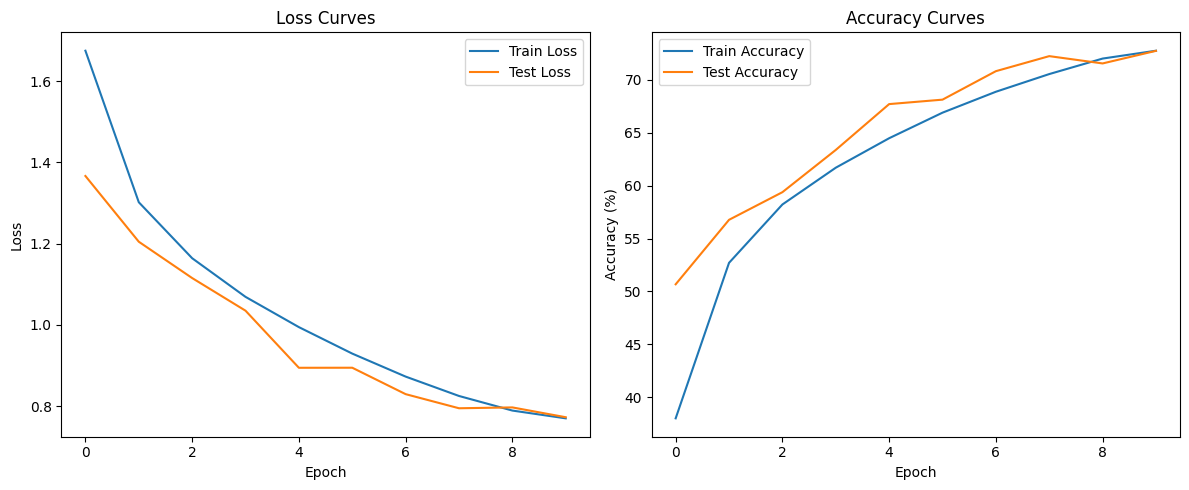

Training complete. Model saved to vit_cifar10.pth


In [ ]:


# Hyperparameters
batch_size = 128
num_epochs = 10
learning_rate = 3e-4
weight_decay = 1e-4

image_size = 32
patch_size = 4
num_classes = 10
dim = 256
depth = 6
heads = 8
mlp_dim = 512
channels = 3
dropout = 0.1

# Data Loading and Preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class SinCos2DPositionalEncoding(nn.Module):
    def __init__(self, dim, h=8, w=8):
        super(SinCos2DPositionalEncoding, self).__init__()
        
        # Create 2D positional encoding
        pos_enc = torch.zeros(h, w, dim)
        
        # Separate channels for width and height dimensions
        dim_h = dim // 2
        dim_w = dim // 2
        
        # Position indices
        y_pos = torch.arange(h).unsqueeze(1).repeat(1, w).reshape(h, w)
        x_pos = torch.arange(w).unsqueeze(0).repeat(h, 1).reshape(h, w)
        
        # Create division term for computing positional encoding values
        div_term_h = torch.exp(torch.arange(0, dim_h, 2).float() * -(math.log(10000.0) / dim_h))
        div_term_w = torch.exp(torch.arange(0, dim_w, 2).float() * -(math.log(10000.0) / dim_w))
        
        # Apply sin and cos to odd and even indices
        for i in range(0, dim_h, 2):
            if i < dim_h:
                pos_enc[:, :, i] = torch.sin(y_pos.float() * div_term_h[i//2])
                pos_enc[:, :, i+1] = torch.cos(y_pos.float() * div_term_h[i//2])
            
        for i in range(0, dim_w, 2):
            if i + dim_h < dim:
                pos_enc[:, :, i+dim_h] = torch.sin(x_pos.float() * div_term_w[i//2])
                pos_enc[:, :, i+dim_h+1] = torch.cos(x_pos.float() * div_term_w[i//2])
        
        # Flatten the positional encoding to match the sequence format (h*w, dim)
        pos_enc = pos_enc.reshape(h * w, dim)
        
        # Add extra position for class token
        cls_pos_enc = torch.zeros(1, dim)
        pos_enc = torch.cat([cls_pos_enc, pos_enc], dim=0)
        
        # Register as buffer (persistent but not model parameter)
        self.register_buffer('pos_enc', pos_enc.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pos_enc

class SinCos2DPositionalEncodingAppend:
    def __init__(self, pos_dim, h, w):
        """
        Generate 2D sinusoidal positional encodings for image patches
        
        Args:
            pos_dim: Dimension of the positional encoding vector
            h: Number of patches in height dimension
            w: Number of patches in width dimension
        """
        self.pos_dim = pos_dim
        self.h = h
        self.w = w
        
        # Initialize positional encodings
        self.generate_encodings()
        
    def generate_encodings(self):
        # Create position indices
        y_pos = torch.arange(self.h).unsqueeze(1).repeat(1, self.w).reshape(self.h, self.w)
        x_pos = torch.arange(self.w).unsqueeze(0).repeat(self.h, 1).reshape(self.h, self.w)
        
        # Split dimensions for height and width
        dim_h = self.pos_dim // 2
        dim_w = self.pos_dim - dim_h  # In case pos_dim is odd
        
        # Division terms for computing positional encoding
        div_term_h = torch.exp(torch.arange(0, dim_h, 2).float() * -(math.log(10000.0) / dim_h))
        div_term_w = torch.exp(torch.arange(0, dim_w, 2).float() * -(math.log(10000.0) / dim_w))
        
        # Create positional encoding tensor
        pos_enc = torch.zeros(self.h, self.w, self.pos_dim)
        
        # Apply sin and cos to encode height positions
        for i in range(0, dim_h, 2):
            if i < dim_h:
                pos_enc[:, :, i] = torch.sin(y_pos.float() * div_term_h[i//2])
                if i + 1 < dim_h:
                    pos_enc[:, :, i+1] = torch.cos(y_pos.float() * div_term_h[i//2])
        
        # Apply sin and cos to encode width positions
        for i in range(0, dim_w, 2):
            if i + dim_h < self.pos_dim:
                pos_enc[:, :, i+dim_h] = torch.sin(x_pos.float() * div_term_w[i//2])
                if i + dim_h + 1 < self.pos_dim:
                    pos_enc[:, :, i+dim_h+1] = torch.cos(x_pos.float() * div_term_w[i//2])
        
        # Reshape to (h*w, pos_dim)
        self.pos_enc = pos_enc.reshape(self.h * self.w, self.pos_dim)
        
        # Create a special positional encoding for the class token
        self.cls_pos_enc = torch.zeros(1, self.pos_dim)

# Multi-head Self Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.heads = heads
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        b, n, c = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, self.heads, self.head_dim).transpose(1, 2), qkv)
        
        # Attention
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(dots, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to v
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(b, n, c)
        out = self.to_out(out)
        return out

# MLP Block
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)

# Transformer Encoder Block
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_dim, dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Vision Transformer
class ViT(nn.Module):
    def __init__(
        self, 
        image_size, 
        patch_size, 
        num_classes, 
        dim, 
        depth, 
        heads, 
        mlp_dim, 
        channels=3, 
        dropout=0.1
    ):
        super(ViT, self).__init__()
        assert image_size % patch_size == 0, 'Image size must be divisible by patch size'
        self.num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        
        self.patch_size = patch_size
        self.h_patches = image_size // patch_size
        self.w_patches = image_size // patch_size
        
        # Patch embedding
        self.to_patch_embedding = nn.Linear(patch_dim, dim)
        
        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Positional encoding - 2D version
        self.pos_embedding = SinCos2DPositionalEncoding(dim, h=self.h_patches, w=self.w_patches)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_dim, dropout) for _ in range(depth)
        ])
        
        # MLP Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        
    def forward(self, img):
        # Get batch size and reshape image into patches
        b, c, h, w = img.shape
        
        # Split image into patches
        patches = img.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 1, 3, 4).contiguous().view(b, -1, c * self.patch_size * self.patch_size)
        
        # Project patches to embedding dimension
        x = self.to_patch_embedding(patches)
        
        # Add class token
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional encoding - now 2D aware
        x = self.pos_embedding(x)
        x = self.dropout(x)
        
        # Apply transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        # Get the class token representation
        x = x[:, 0]
        
        # MLP head
        return self.mlp_head(x)

# Create model, optimizer, and loss function
model = ViT(
    image_size = image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    channels=channels,
    dropout=dropout
).to(device)

# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# criterion = nn.CrossEntropyLoss()

# # Training loop
# train_losses = []
# train_accs = []
# test_losses = []
# test_accs = []

def train_one_epoch(model, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    return test_loss, test_acc

# Main training loop
# for epoch in range(num_epochs):
#     # Train
#     train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
#     train_losses.append(train_loss)
#     train_accs.append(train_acc)
    
#     # Test
#     test_loss, test_acc = test(model, test_loader, criterion)
#     test_losses.append(test_loss)
#     test_accs.append(test_acc)
    
#     # Update learning rate
#     scheduler.step()
    
#     print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# # Plot training and testing curves
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Curves')

# plt.subplot(1, 2, 2)
# plt.plot(train_accs, label='Train Accuracy')
# plt.plot(test_accs, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.title('Accuracy Curves')

# plt.tight_layout()
# plt.savefig('vit_training_curves.png')
# plt.show()

# # Save the model
# torch.save(model.state_dict(), 'vit_cifar10.pth')
# print('Training complete. Model saved to vit_cifar10.pth')


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.fft as fft

class FrequencyPixelAttacks(nn.Module):
    """
    A PyTorch transform to apply various frequency-based and pixel-based attacks.
    """
    def __init__(self, attack_type='phase', epsilon=0.1, frequency_radius=0.1, num_pixels=100, noise_std=0.05, seed=None):
        super(FrequencyPixelAttacks, self).__init__()
        self.attack_type = attack_type
        self.epsilon = epsilon
        self.frequency_radius = frequency_radius
        self.num_pixels = num_pixels
        self.noise_std = noise_std
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def forward(self, img):
        perturbed_img = img.clone().detach()
        if self.attack_type == 'phase':
            perturbed_img = self._phase_attack(perturbed_img)
        elif self.attack_type == 'magnitude':
            perturbed_img = self._magnitude_attack(perturbed_img)
        elif self.attack_type == 'low_freq':
            perturbed_img = self._low_frequency_attack(perturbed_img)
        elif self.attack_type == 'high_freq':
            perturbed_img = self._high_frequency_attack(perturbed_img)
        elif self.attack_type == 'pixel':
            perturbed_img = self._pixel_attack(perturbed_img)
        elif self.attack_type == 'normal':
            perturbed_img = self._normal_noise_attack(perturbed_img)
        else:
            raise ValueError(f"Unknown attack type: {self.attack_type}")
        return torch.clamp(perturbed_img, 0, 1)
    
    def _phase_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            phase_noise = torch.randn_like(phase) * self.epsilon
            perturbed_phase = phase + phase_noise
            f_transform_perturbed = magnitude * torch.exp(1j * perturbed_phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _magnitude_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            magnitude_noise = torch.randn_like(magnitude) * self.epsilon * magnitude
            perturbed_magnitude = magnitude + magnitude_noise
            f_transform_perturbed = perturbed_magnitude * torch.exp(1j * phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _create_frequency_mask(self, height, width, is_low_freq=True):
        y_indices, x_indices = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
        y_indices = y_indices - height // 2
        x_indices = x_indices - width // 2
        distance = torch.sqrt(y_indices**2 + x_indices**2).float()
        max_distance = torch.sqrt(torch.tensor(height**2 + width**2, dtype=torch.float32))
        distance /= max_distance
        return (distance <= self.frequency_radius).float() if is_low_freq else (distance >= (1 - self.frequency_radius)).float()
    
    def _low_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=True).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _high_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=False).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _pixel_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = img.clone()
        num_pixels = min(self.num_pixels, height * width)
        pixel_indices = torch.randint(0, height * width, (batch, num_pixels))
        y_indices, x_indices = pixel_indices // width, pixel_indices % width
        for b in range(batch):
            for c in range(channels):
                for i in range(num_pixels):
                    perturbed_img[b, c, y_indices[b, i], x_indices[b, i]] += torch.randn(1).item() * self.epsilon
        return perturbed_img
    
    def _normal_noise_attack(self, img):
        noise = torch.randn_like(img) * self.noise_std
        return img + noise
    


In [ ]:
# attack = FrequencyPixelAttacks(attack_type='phase', epsilon=0.1, frequency_radius=0.1, num_pixels=100, noise_std=0.05, seed=42)
# Example of applying the attack and finding reduced accuracy
def apply_attack_and_evaluate(model, data_loader, attack):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            perturbed_inputs = attack(inputs)
            outputs = model(perturbed_inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy
# Evaluate the model on clean data
# _, clean_acc = test(model, test_loader, criterion)

# print(f'Clean Accuracy: {clean_acc:.2f}%')
# # Evaluate the model on perturbed data
# perturbed_accuracy = apply_attack_and_evaluate(model, test_loader, attack)
# print(f'Perturbed Accuracy: {perturbed_accuracy:.2f}%')

Test Loss: 0.7729, Test Acc: 72.73%
Clean Accuracy: 72.73%
Perturbed Accuracy: 33.36%


In [ ]:
batch_size = 128
num_epochs = 10
learning_rate = 3e-4
weight_decay = 1e-4

image_size = 32
num_classes = 10
channels = 3


# patch_size = 4
# dim = 256
# depth = 6
# heads = 8
# mlp_dim = 512
# dropout = 0.1

patch_sizes = [2, 4, 8]
dims = [64, 128, 256]
depths = [6, 8, 12]
heads = [4, 8, 12]
# MLP dimension is taken as 2 * dim

def create_model(patch_size, depth, heads, mlp_dim):
    return ViT(
        image_size=image_size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=dim,
        depth=depth,
        heads=heads,
        mlp_dim=mlp_dim,
        channels=channels,
        dropout=dropout
    ).to(device)


In [ ]:
import pandas as pd
import itertools
results = pd.DataFrame(columns=['Patch Size', 'Dim', 'Depth', 'Heads', 'Accuracy', 'phase', 'magnitude', 'low_freq', 'high_freq', 'pixel', 'normal'])

for params in itertools.product(patch_sizes, dims, depths, heads):
    patch_size, dim, depth, heads = params
    model = create_model(patch_size, depth, heads, mlp_dim).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
        test_loss, test_acc = test(model, test_loader, criterion)
        scheduler.step()
    
    # Evaluate the model on clean data
    _, clean_acc = test(model, test_loader, criterion)
    
    # Evaluate the model on perturbed data
    perturbed_accuracy_phase = apply_attack_and_evaluate(model, test_loader, FrequencyPixelAttacks(attack_type='phase', epsilon=0.1))
    perturbed_accuracy_magnitude = apply_attack_and_evaluate(model, test_loader, FrequencyPixelAttacks(attack_type='magnitude', epsilon=0.1))
    perturbed_accuracy_low_freq = apply_attack_and_evaluate(model, test_loader, FrequencyPixelAttacks(attack_type='low_freq', epsilon=0.1))
    perturbed_accuracy_high_freq = apply_attack_and_evaluate(model, test_loader, FrequencyPixelAttacks(attack_type='high_freq', epsilon=0.1))
    perturbed_accuracy_pixel = apply_attack_and_evaluate(model, test_loader, FrequencyPixelAttacks(attack_type='pixel', num_pixels=100))
    perturbed_accuracy_normal = apply_attack_and_evaluate(model, test_loader, FrequencyPixelAttacks(attack_type='normal', noise_std=0.05))
    
    results.loc[len(results)] = [patch_size, dim, depth, heads,
                                  clean_acc,
                                  perturbed_accuracy_phase,
                                  perturbed_accuracy_magnitude,
                                  perturbed_accuracy_low_freq,
                                  perturbed_accuracy_high_freq,
                                  perturbed_accuracy_pixel,
                                  perturbed_accuracy_normal]
    # Save the results to a CSV file
    results.to_csv('vit_attack_results.csv', index=False)
    print(f"Results for Patch Size: {patch_size}, Dim: {dim}, Depth: {depth}, Heads: {heads}: {results.iloc[-1]}")